# Machine Learning: Satellite Image to Land Cover

# Section 0: Load Packages

In [ ]:
import sys
import sklearn
import os
import re
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from functools import partial
import PIL
import PIL.Image
from keras.models import model_from_json

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(49) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(49)

In [ ]:
from platform import python_version
python_version()

'3.7.10'

In [ ]:
import tensorflow as tf
tf.__version__

'2.4.1'

# Section I: Import Data and pre-processing

Here, we import a satellite image `LC08_July2019.tif`. \

This image is downloaded from the USGS EarthExplorer:
https://earthexplorer.usgs.gov/
Image is from dataset Landsat 8 OLI/TIRS (Operational Land Imager / Thermal Infrared Sensor) C2 L1, path 014 and row 034. cloud cover less than 5%, acquired on 07/20/2019. This dataset has a total of 11 bands, in which band 2, 3, 4 are blue, green, and red channels at 30m resolution. Furthermore, we used a 3-party program `Spectral Discovery for Landsat-8` from:
https://www.satelliteimagery360.com/
to merge these three bands together and resulted a 15m colored satellite image of Virginia coast, i.e., `LC08_July2019.tif`.

We further sliced this image into two images, one will be manually splitted and labeled for training and validation. The other will be saved for testing/demo purpose.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
filepath='/content/drive/MyDrive/Colab Notebooks/images/'

In [ ]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image

In [ ]:
PIL.Image.MAX_IMAGE_PIXELS = 933120000

In [ ]:
im=PIL.Image.open(filepath+'LC08_July2019.tif')

In [ ]:
imarray=np.array(im)

In [ ]:
imarray.shape

(15761, 15501, 3)

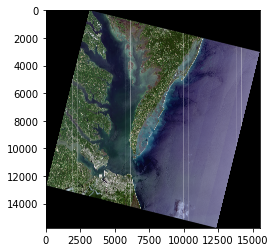

In [ ]:
plt.imshow(imarray)

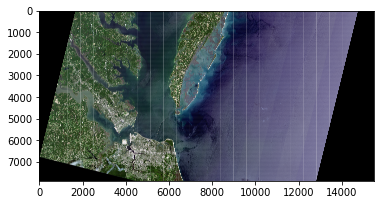

In [ ]:
rows=np.array_split(imarray,8)
row_mid=np.concatenate((rows[3],rows[4],rows[5],rows[6]))
plt.imshow(row_mid)

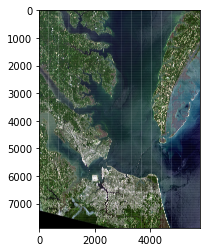

In [ ]:
cols=np.array_split(row_mid, 8, axis=1)
newpic=np.concatenate((cols[1],cols[2],cols[3]),axis=1)
plt.imshow(newpic)

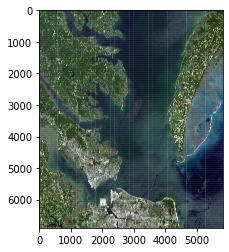

In [ ]:
rows=np.array_split(newpic,8)
pic=np.concatenate((rows[0],rows[1],rows[2],rows[3],rows[4],rows[5],rows[6]))
plt.imshow(pic)

In [ ]:
left, right=np.array_split(pic,2, axis=1)

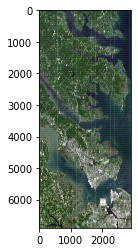

In [ ]:
plt.imshow(left)

In [ ]:
_,test,train,_=np.array_split(left,4)

## Test is for testing/demo purpose, saved for later

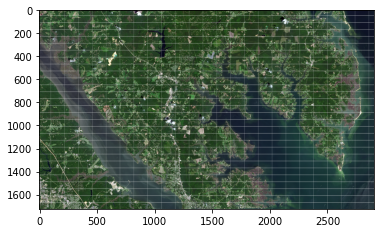

In [ ]:
plt.imshow(test)

In [ ]:
im2=PIL.Image.fromarray(test)
im2.save(filepath+"testimage.tiff")
#im2.save("newpic.jpg")

In [ ]:
im2=PIL.Image.fromarray(train)
im2.save(filepath+"trainimage.tiff")
#im2.save("newpic.jpg")

## Train will be used for model training and validation

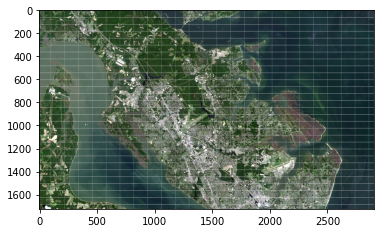

In [ ]:
plt.imshow(train)

In [ ]:
test.shape

(1724, 2907, 3)

In [ ]:
# function to generate splitted figures
def save_split(imagearray, row_num, col_num, folder):
    from PIL import Image
    import os
    split_dict={}
    rows=np.array_split(imagearray, row_num)
    for r in range(row_num):
        columns=np.array_split(rows[r], col_num, axis=1)
        for c in range(col_num):
            split_dict['subfig_'+str(r)+'_'+str(c)] = columns[c]
    shutil.rmtree(folder, ignore_errors=True)
    if not os.path.exists(folder+'folder'):
        os.makedirs(folder+'folder')
    for key in split_dict:
        fig=Image.fromarray(split_dict[key])
        fig.save(folder+'folder/'+key+'.jpg')  

In [ ]:
# run the function to generate these figures
row_num=30
col_num=50

folder='/content/drive/MyDrive/subfigs/'

save_split(train, row_num, col_num, folder)

# Section II: Model training

## Import Data from google drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## this filepath contains all manually sorted 1500 figures into 10 sub-directories

In [ ]:
filepath='/content/drive/MyDrive/sorted/'

In [ ]:
# our 10 categories, i.e., folder names in alphanumeric order:
class_names = ['airport', 'commercial', 'farmland', 'forest', 
  'lake', 'marsh', 'ocean', 'residential', 'seashore', 'sound']

In [ ]:
row_num=30
col_num=50

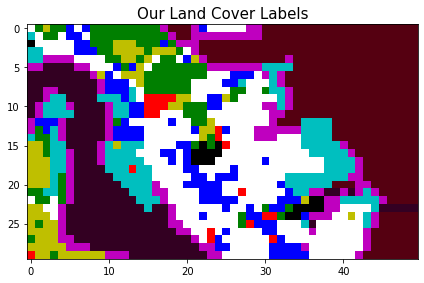

In [ ]:
# this is to preview our manually labeled map
# we mapped the category of each splitted rectangle into their corresponding 
# positions in a numpy array

subdirs=sorted([d for d in os.listdir(filepath)])
colormat=np.zeros((row_num, col_num))
for idx, dir in enumerate(subdirs):
    allfiles=sorted(os.listdir(filepath+dir))
    for file in allfiles:
        fnsp=re.split('_|\.',file)
        row_idx=int(fnsp[1])
        col_idx=int(fnsp[2])
        colormat[row_idx][col_idx]=idx

#this is a function to map number to color
def plot_matrix(rm, title='Mapped Figure', cmap=plt.cm.Blues):
    plt.figure(figsize=(6,10))
    plt.imshow(rm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=15)
    plt.tight_layout()
    plt.show()
# a customized color map
cmap = colors.ListedColormap(['k','b','y','g','r','c','#550011','w','m','#330022'])

plot_matrix(colormat,'Our Land Cover Labels',cmap=cmap)

In [ ]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = filepath
batch_size = 16;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
# I changed dimensions to 224 in anticipation of using Xception.
img_height = 224; 
img_width = 224;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 49,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Test Dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 49,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        

Found 1500 files belonging to 10 classes.
Using 1200 files for training.
Found 1500 files belonging to 10 classes.
Using 300 files for validation.


In [ ]:
train_ds.take(1)

<TakeDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

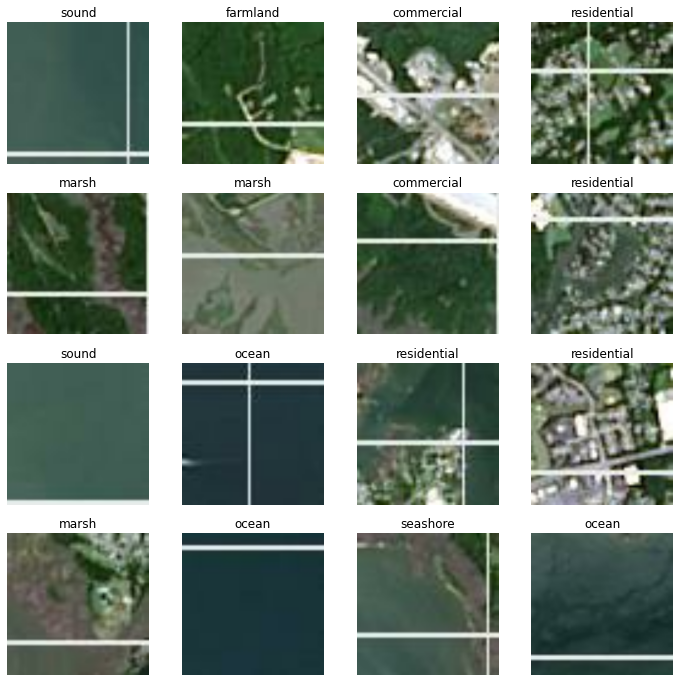

In [ ]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['airport', 'commercial', 'farmland', 'forest', 
  'lake', 'marsh', 'ocean', 'residential', 'seashore', 'sound']

# Rows and columns are set to fit one training batch (16)
n_rows = 4
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


## Baseline Model

In [ ]:
n_classes=10

In [ ]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
baseline_model = keras.Sequential([
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(n_classes, activation='softmax')
])

In [ ]:
# baseline model
optimizer = keras.optimizers.Nadam(learning_rate=0.0001)

loss_function = "sparse_categorical_crossentropy"

baseline_model.compile(loss=loss_function, optimizer=optimizer,
              metrics=["accuracy"])
history = baseline_model.fit(train_ds,
                    steps_per_epoch=len(train_ds),
                    validation_data=test_ds,
                    validation_steps=len(test_ds),
                    epochs=15,
                    shuffle="batch",
                    batch_size=10)

Epoch 1/15
75/75 [==============================] - 5s 57ms/step - loss: 19.7203 - accuracy: 0.3216 - val_loss: 1.3129 - val_accuracy: 0.6000
Epoch 2/15
75/75 [==============================] - 4s 54ms/step - loss: 0.8935 - accuracy: 0.7097 - val_loss: 1.3247 - val_accuracy: 0.6267
Epoch 3/15
75/75 [==============================] - 4s 54ms/step - loss: 0.4165 - accuracy: 0.8751 - val_loss: 1.3356 - val_accuracy: 0.6667
Epoch 4/15
75/75 [==============================] - 4s 54ms/step - loss: 0.2792 - accuracy: 0.9293 - val_loss: 1.3156 - val_accuracy: 0.6867
Epoch 5/15
75/75 [==============================] - 4s 54ms/step - loss: 0.1647 - accuracy: 0.9549 - val_loss: 1.4212 - val_accuracy: 0.6900
Epoch 6/15
75/75 [==============================] - 4s 55ms/step - loss: 0.1813 - accuracy: 0.9507 - val_loss: 1.5832 - val_accuracy: 0.6533
Epoch 7/15
75/75 [==============================] - 4s 55ms/step - loss: 0.1247 - accuracy: 0.9630 - val_loss: 1.6917 - val_accuracy: 0.6833
Epoch 8/15
7

19/19 - 1s - loss: 2.1517 - accuracy: 0.6800


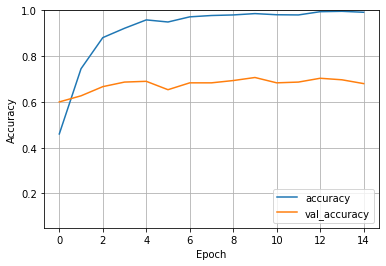

In [ ]:
# Plot baseline model accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.05, 1])
plt.legend(loc='lower right')

test_loss, test_acc = baseline_model.evaluate(test_ds, verbose=2)

## We take advantage of Xception model for transfer learning

In [ ]:
n_classes=10

In [ ]:
# base_model = keras.applications.xception.Xception(weights="imagenet",
#                                                   include_top=False, classes=n_classes)
# avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
# output = keras.layers.Dense(n_classes, activation="softmax")(avg)
# model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(200,activation='elu')(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(170,activation='elu')(x)
predictions = keras.layers.Dense(n_classes, activation='softmax')(x)
model = keras.models.Model(inputs=base_model.input, outputs=predictions)

model = keras.models.Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  model
])


83689472/83683744 [==============================] - 2s 0us/step


In [ ]:
for layer in base_model.layers:
     layer.trainable = False

optimizer = keras.optimizers.Nadam(lr=0.01, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_ds, 
                    steps_per_epoch=len(train_ds),
                    validation_data=test_ds,
                    validation_steps=len(test_ds), 
                    epochs=20)

Epoch 1/20
75/75 [==============================] - 10s 83ms/step - loss: 3.7738 - accuracy: 0.3243 - val_loss: 1.2362 - val_accuracy: 0.4933
Epoch 2/20
75/75 [==============================] - 5s 67ms/step - loss: 1.4493 - accuracy: 0.4858 - val_loss: 1.6431 - val_accuracy: 0.4533
Epoch 3/20
75/75 [==============================] - 5s 67ms/step - loss: 1.4566 - accuracy: 0.4974 - val_loss: 1.1637 - val_accuracy: 0.4933
Epoch 4/20
75/75 [==============================] - 5s 66ms/step - loss: 1.3279 - accuracy: 0.5248 - val_loss: 1.2122 - val_accuracy: 0.4767
Epoch 5/20
75/75 [==============================] - 5s 67ms/step - loss: 1.2534 - accuracy: 0.5458 - val_loss: 1.2410 - val_accuracy: 0.4500
Epoch 6/20
75/75 [==============================] - 5s 67ms/step - loss: 1.3481 - accuracy: 0.5137 - val_loss: 1.2879 - val_accuracy: 0.6033
Epoch 7/20
75/75 [==============================] - 5s 67ms/step - loss: 1.4112 - accuracy: 0.5547 - val_loss: 1.4743 - val_accuracy: 0.4700
Epoch 8/20
7

In [ ]:
from keras.callbacks import Callback

class TerminateOnBaseline(Callback):
    """Callback that terminates training when either acc or val_acc reaches a specified baseline
    """
    def __init__(self, monitor='accuracy', baseline=0.9):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.Nadam(learning_rate=0.0001)

loss_function = "sparse_categorical_crossentropy"

model.compile(loss=loss_function, optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_ds,
                    callbacks = [TerminateOnBaseline(monitor='val_accuracy', baseline=0.86)],
                    steps_per_epoch=len(train_ds),
                    validation_data=test_ds,
                    validation_steps=len(test_ds),
                    epochs=100,
                    shuffle="batch",
                    batch_size=10)

Epoch 1/100
75/75 [==============================] - 27s 191ms/step - loss: 1.5656 - accuracy: 0.4237 - val_loss: 1.0735 - val_accuracy: 0.6767
Epoch 2/100
75/75 [==============================] - 14s 182ms/step - loss: 0.9943 - accuracy: 0.6464 - val_loss: 0.9719 - val_accuracy: 0.6967
Epoch 3/100
75/75 [==============================] - 14s 182ms/step - loss: 0.8623 - accuracy: 0.7142 - val_loss: 0.8413 - val_accuracy: 0.7133
Epoch 4/100
75/75 [==============================] - 14s 182ms/step - loss: 0.7359 - accuracy: 0.7455 - val_loss: 0.8534 - val_accuracy: 0.7267
Epoch 5/100
75/75 [==============================] - 14s 182ms/step - loss: 0.6542 - accuracy: 0.7703 - val_loss: 0.6348 - val_accuracy: 0.8000
Epoch 6/100
75/75 [==============================] - 14s 182ms/step - loss: 0.5620 - accuracy: 0.8186 - val_loss: 0.6372 - val_accuracy: 0.8000
Epoch 7/100
75/75 [==============================] - 14s 182ms/step - loss: 0.4901 - accuracy: 0.8400 - val_loss: 0.6604 - val_accuracy:

In [ ]:
model.evaluate(test_ds)

19/19 [==============================] - 1s 42ms/step - loss: 0.5874 - accuracy: 0.8600


[0.5873769521713257, 0.8600000143051147]

We have 86% accuracy on this test_ds. The next step is to test on a true dataset, I have a figure saved as test in the first notebook. We need to use the image_split() and save_jpg() to create a similar set of data for testing. The idea is to map our prediction on top of the figure.

19/19 - 1s - loss: 0.5874 - accuracy: 0.8600


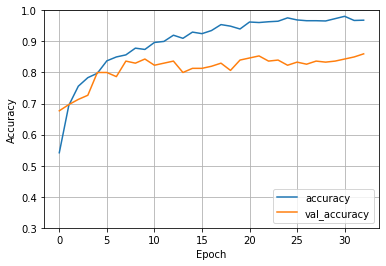

In [ ]:
# Plot model accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_ds, verbose=2)

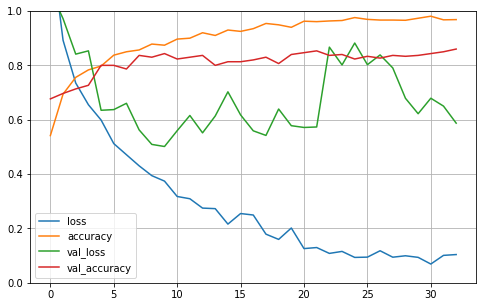

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## This is to visually inspect our model performance on the validation data
### The true labels are on the top center in black, and our trained result is on the top left corner in red.

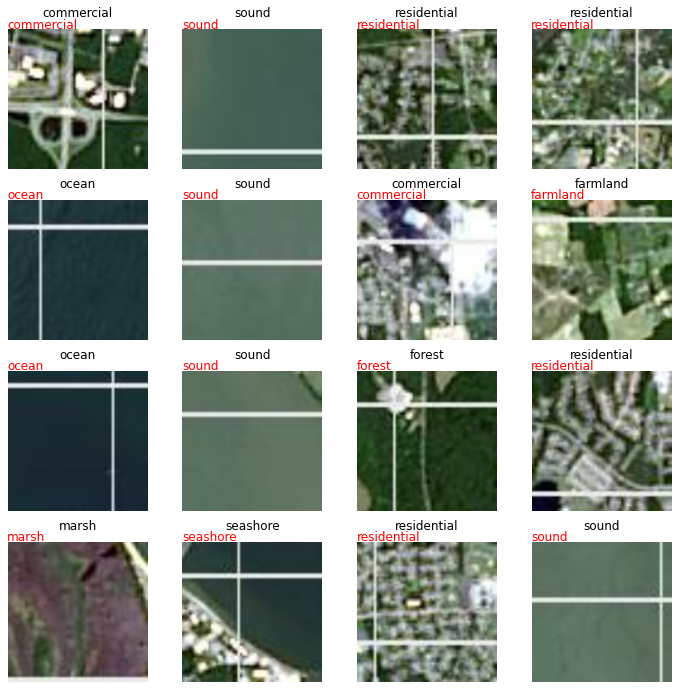

In [ ]:
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in test_ds.take(1):
    class_pred=np.argmax(model.predict(images), axis=-1)
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12, y=1.05)
        plt.text(-1,-3,class_names[class_pred[i]],fontsize=12, color='red')
plt.subplots_adjust(wspace=.2, hspace=.22)

## to visualize training/validation result on our train/validation map:

Found 1500 files belonging to 1 classes.


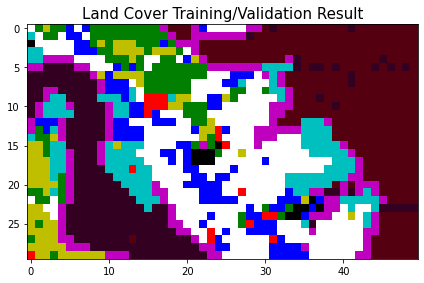

In [ ]:
# this is to show the whole picture of our landcover classification

trainfolder='/content/drive/MyDrive/subfigs/'

img_height = 224; 
img_width = 224;

trainfigs = tf.keras.preprocessing.image_dataset_from_directory(
        trainfolder,
        label_mode=None,
        shuffle=False,
        image_size = (img_height, img_width),
        batch_size=16); 

allfiles=sorted(os.listdir(trainfolder+'folder'))
colormat=np.zeros((row_num, col_num))
a1=np.argmax(model.predict(trainfigs), axis=-1)
for idx, file in enumerate(allfiles):
    fnsp=re.split('_|\.',file)
    row_idx=int(fnsp[1])
    col_idx=int(fnsp[2])
    colormat[row_idx][col_idx]=a1[idx]

plot_matrix(colormat,'Land Cover Training/Validation Result',cmap=cmap)
  


## To save our model to google drive, more convenient for testing later

In [ ]:
#this is to load/save model, no need to train model everytime!

# serialize model to JSON
model_json = model.to_json()
with open("drive/MyDrive/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("drive/MyDrive/model.h5")
print("Saved model to disk")

# later...
 
# load json and create model
#json_file = open('drive/MyDrive/model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#model = model_from_json(loaded_model_json)
# load weights into new model
#model.load_weights("drive/MyDrive/model.h5")
#print("Loaded model from disk")

Saved model to disk


## A different way of model saving:

In [ ]:
filepath='/content/drive/MyDrive/'

In [ ]:
#model_version='0001'
#model_name='my_satellite_landcover'
#model_path=os.path.join(model_name,model_version)
#tf.saved_model.save(model,filepath+model_path)

# Section III: Model Testing

## Reload model:



In [ ]:
# load json and create model

json_file = open('drive/MyDrive/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("drive/MyDrive/model.h5")
print("Loaded model from disk")

Loaded model from disk


## We load an unseen satellite picture for a true test:

In [ ]:
testfolder='/content/drive/MyDrive/Colab Notebooks/images/'

In [ ]:
testimage=PIL.Image.open(testfolder+'testimage.tiff')

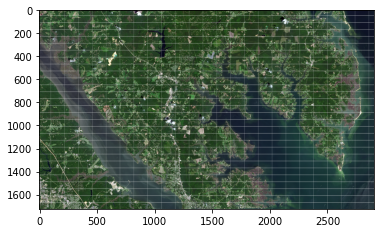

In [ ]:
testarray=np.array(testimage)
plt.imshow(testarray)

In [ ]:
# set the folder, size for splitted figures
testfolder='/content/testsubfig/'

# split the figure in the exact resolution as the training data
row_num=30
col_num=50

In [ ]:
# run the function to generate these figures
save_split(testarray, row_num, col_num, testfolder)

Found 1500 files belonging to 1 classes.


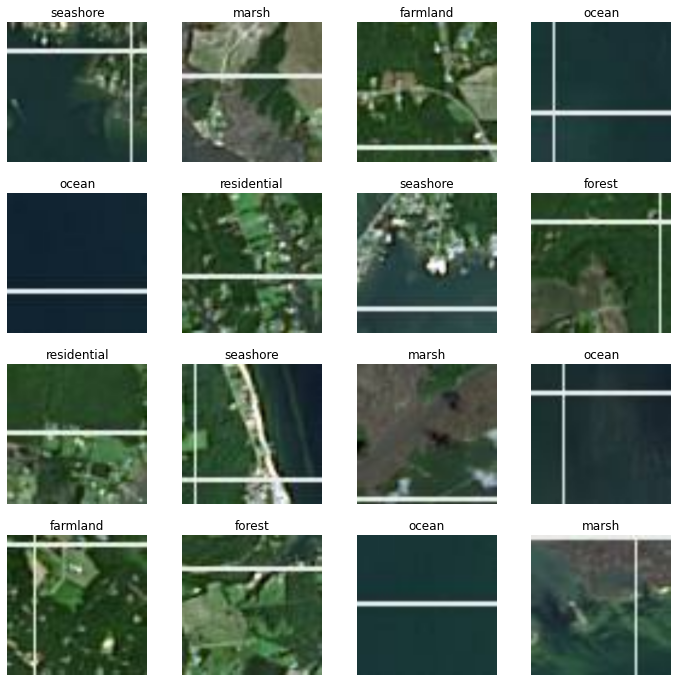

In [ ]:
# this is to show predictions using our trained model

img_height = 224; 
img_width = 224;
n_rows = 4
n_cols = 4

class_names = ['airport', 'commercial', 'farmland', 'forest', 
  'lake', 'marsh', 'ocean', 'residential', 'seashore', 'sound']

testfigs = tf.keras.preprocessing.image_dataset_from_directory(
    testfolder,
    label_mode=None,
    shuffle=True,
    image_size = (img_height, img_width),
    batch_size=16) 

plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images in testfigs.take(1):
    class_pred=np.argmax(model.predict(images), axis=-1)
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[class_pred[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.22)

Found 1500 files belonging to 1 classes.


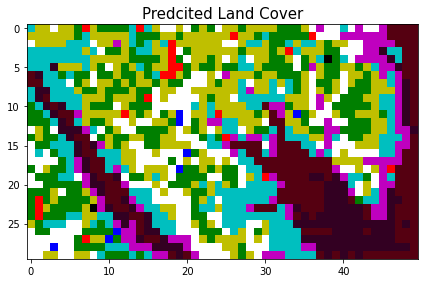

In [ ]:
# this is to show the whole picture of our landcover classification

testfigs = tf.keras.preprocessing.image_dataset_from_directory(
        testfolder,
        label_mode=None,
        shuffle=False,
        image_size = (img_height, img_width),
        batch_size=16); 

allfiles=sorted(os.listdir(testfolder+'folder'))
colormat=np.zeros((row_num, col_num))
a1=np.argmax(model.predict(testfigs), axis=-1)
for idx, file in enumerate(allfiles):
    fnsp=re.split('_|\.',file)
    row_idx=int(fnsp[1])
    col_idx=int(fnsp[2])
    colormat[row_idx][col_idx]=a1[idx]

plot_matrix(colormat,'Predcited Land Cover',cmap=cmap)
  


## To compare to our original test satellite image:

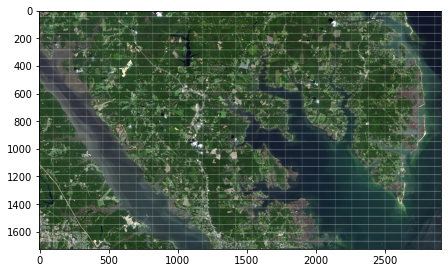

In [ ]:
plt.figure(figsize=(7.2,12))
plt.imshow(testarray)

## We can also split this figure into a different grid size, for example, we double both row and column numbers:

In [ ]:
row_num=60
col_num=100

Found 6000 files belonging to 1 classes.


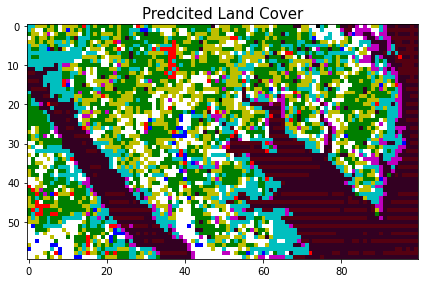

In [ ]:
save_split(testarray, row_num, col_num, testfolder)

testfigs = tf.keras.preprocessing.image_dataset_from_directory(
        testfolder,
        label_mode=None,
        shuffle=False,
        image_size = (img_height, img_width),
        batch_size=16); 

allfiles=sorted(os.listdir(testfolder+'folder'))
colormat=np.zeros((row_num, col_num))
a1=np.argmax(model.predict(testfigs), axis=-1)
for idx, file in enumerate(allfiles):
    fnsp=re.split('_|\.',file)
    row_idx=int(fnsp[1])
    col_idx=int(fnsp[2])
    colormat[row_idx][col_idx]=a1[idx]

plot_matrix(colormat,'Predcited Land Cover',cmap=cmap)

In [ ]:
%%javascript
IPython.notebook.save_notebook()
IPython.notebook.kernel.execute("!jupyter nbconvert --to html " + IPython.notebook.notebook_name)